In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ls "/content/drive/MyDrive/DATASET"

 DATASET_ADAMALIK.csv  'DATA TEST'/   FITUR/  'Pengukuran Darah'/


#PENGUKURAN PENGGUNAAN SMARTPHONE


In [ ]:
import cv2
import numpy as np
from scipy import signal
import os
import shutil

overall_results = []

def HeartRateFinger(Video_Path):
    os.makedirs("frames")  #make a directory called frames to save the images in
    vidcap = cv2.VideoCapture(Video_Path)  #the directory path to the video of interest
    images = []

    #take in images and get indidvual frames
    def getFrame(sec):
        vidcap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)  #VideoCaptureProperties to capture 
        hasFrames, image = vidcap.read()
        if hasFrames:
            cv2.imwrite("frames/image" + str(count) + ".jpg", image)  # save frame as JPG file
        images.append("frames/image" + str(count) + ".jpg")
        return hasFrames

    #set up frame rate
    sec = 0
    frameRate = 0.05  #capture frame each 0.05 seconds --> (1 second) / .05 = 20 seconds 20 fps
    count = 1
    success = getFrame(sec)  #success tracker
    while (success):
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(sec)

    #Get the channels from images and Find the average of RED channel for each frame
    pixels_averages = []
    for i in range(len(images) - 1):
        bgr_image = cv2.imread(images[i])
        blue_channel, green_channel, red_channel = cv2.split(bgr_image)  #splits into the 3 color channels (RGB)
        average = np.mean(red_channel)  #mean of all the red channels  is the sum all pixels in channel and divide by number of pixels
        pixels_averages.append(average)  #add this average to all the other frames array
    pixels_averages = np.divide(np.array(pixels_averages), 255)  #normalize our averages between 0-1

    #Clean and filter data (butterworth filter)
    sos = signal.butter(4, 1, 'hp', fs=20, output='sos')  # setting up signal.butter(kind of frequency,framerate, name of method)
    filtered = signal.sosfilt(sos, pixels_averages) #Applying filter

    # truncate wonky data from  beginning of series
    filtered = filtered[40:]

    #Perform FFT to find frequency of max amplitude
    Sample_rate = 20  #same as the frame rate is the sampling rate
    BW = Sample_rate / 2  #bandwidth (range of frequency) in signal processing
    fft = np.absolute(np.fft.fft(filtered))
    frames_len = len(filtered)
    frequancies = np.arange(0, BW, Sample_rate / frames_len)
    fft = fft[0:len(frequancies)]

    #Convert back to BPM from hz
    heartrate = np.round(frequancies[np.argmax(fft)] * 60)  #take the highest peak frequency and multiply by 60 and round it
    shutil.rmtree("frames")  #remove folder made to keep the directory clean
    overall_results.append(heartrate)
    return heartrate

In [ ]:
#script expected outcome while Resting is 74-78 BPM
path = "95.MOV"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

Your Heart rate is : 77.0 bpm


In [ ]:
#script expected outcome while Resting is 69-77 BPM
path = "resting1.mp4"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

Your Heart rate is : 70.0 bpm


In [ ]:
#script expected outcome while Resting is 69-77 BPM
path = "RESTING2.mp4"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

Your Heart rate is : 70.0 bpm


In [ ]:
#script expected outcome after activity was 83-88 BPM (50 jumping jacks)
path = "active1.mp4"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

Your Heart rate is : 85.0 bpm


In [ ]:
#script expected outcome after activity was 75-85 BPM (jogging for a bit)
path =  "active2.mp4"
my_heart_rate = HeartRateFinger(path)
print("Your Heart rate is : {} bpm".format(my_heart_rate))

Your Heart rate is : 75.0 bpm


In [ ]:
#Overall results laid out with their error rate as well
print(overall_results)


[77.0, 70.0, 70.0, 85.0, 75.0]


# DATASET PASIEN *RSUP HAJI ADAM MALIK MEDAN


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt

In [7]:
datas = pd.read_excel("/content/drive/MyDrive/DATASET/Pengukuran Darah/DATASET_ADAMALIK.xlsx")

In [8]:
datas.head()

,No,Nama Sample,Jenis Kelamin,Umur,Tekanan Darah (TD),Respiration Rate(RR),Heart Rate(HR),Saturasi Oksigen(SpO2)
0,1.0,M.Hut,Perempuan,62.0,122/66,36.0,132.0,0.83
1,2.0,D.Gin,Laki- Laki,43.0,103/10.8,14.0,145.0,0.98
2,3.0,SAH,Perempuan,60.0,105/71,20.0,110.0,0.98
3,4.0,M.SYA,Laki- Laki,31.0,97/74,32.0,97.0,0.99
4,5.0,A SIB,Laki- Laki,55.0,103/80,28.0,71.0,0.97


In [9]:
#df1 = datas[datas.columns[5:8]] #Irisan pertama
df1 = datas[datas.columns[5:8]]

In [10]:
df1.head()

,Respiration Rate(RR),Heart Rate(HR),Saturasi Oksigen(SpO2)
0,36.0,132.0,0.83
1,14.0,145.0,0.98
2,20.0,110.0,0.98
3,32.0,97.0,0.99
4,28.0,71.0,0.97


Konversi Ke dataset PPG


In [11]:
datas = pd.read_excel("/content/drive/MyDrive/DATASET/Pengukuran Darah/bidmc_53_Signals.xlsx")

In [12]:
datas.head()

,Time [s],RESP,II,V,AVR,PLETH
0,0.000,0.28390,0.19990,0.59531,0.54985,1.3060
1,0.008,0.27339,0.26002,0.58016,0.53519,1.2903
2,0.016,0.26313,0.31476,0.54008,0.50000,1.2747
3,0.024,0.25214,0.32991,0.50000,0.47019,1.2590
4,0.032,0.24139,0.36510,0.45992,0.45992,1.2444


#DENOISING

In [13]:
pip install heartpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.5 MB/s 


In [14]:
import numpy as np
import pandas as pd
import heartpy as hp
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet

In [15]:
data = pd.read_excel('/content/drive/MyDrive/DATASET/Pengukuran Darah/bidmc_53_Signals.xlsx')

In [16]:
data.tail()

,Time [s],RESP,II,V,AVR,PLETH
59996,479.97,0.96286,0.27468,0.44477,0.45015,1.2962
59997,479.98,0.96164,0.26002,0.45503,0.45992,1.2884
59998,479.98,0.96066,0.25464,0.48485,0.45015,1.2786
59999,479.99,0.95749,0.22972,0.57527,0.42473,1.2678
60000,480.00,0.95456,0.31476,0.71017,0.30987,1.2571


In [17]:
ECG = data['II']
PPG = data['PLETH']
time = data['Time [s]']
subject = 2
bellow = 1200
get = 3600

ECG = ECG[bellow:get]
PPG = PPG[bellow:get]
time = time[bellow:get]
ECG = ECG.to_numpy()
PPG = PPG.to_numpy()
time = time.to_numpy()

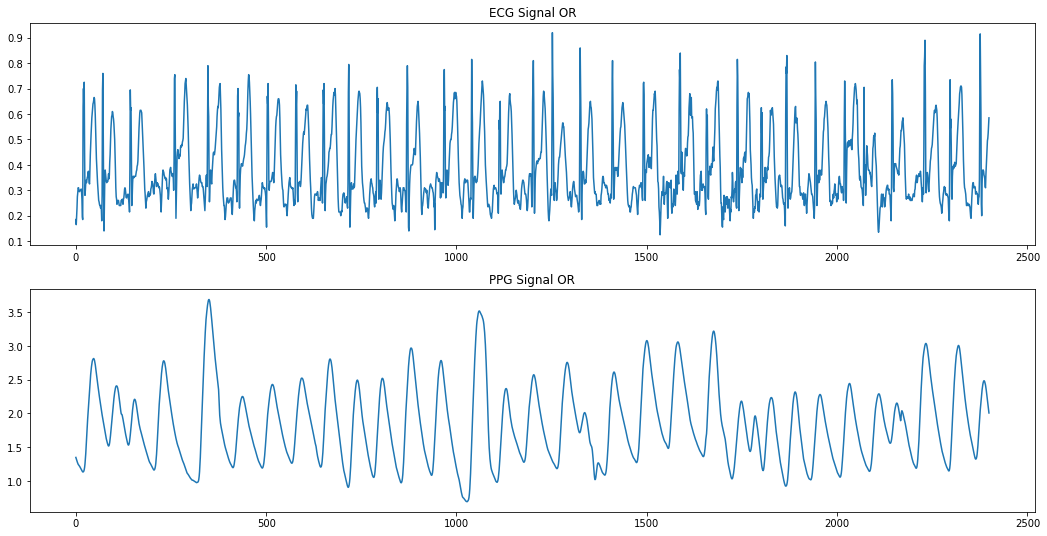

In [18]:

plt.figure(figsize=(18,9))
plt.subplot(211)
plt.plot(ECG)
plt.title('ECG Signal OR')
plt.subplot(212)
plt.plot(PPG)
plt.title('PPG Signal OR')
plt.show()

In [19]:
help(hp.get_samplerate_datetime)

Help on function get_samplerate_datetime in module heartpy.datautils:

get_samplerate_datetime(datetimedata, timeformat='%H:%M:%S.%f')
    determine sample rate based on datetime
    
    Function to determine sample rate of data from datetime-based timer
    list or array.
    
    Parameters
    ----------
    timerdata : 1-d numpy array or list
        sequence containing datetime strings
    
    timeformat : string
        the format of the datetime-strings in datetimedata
        default : '%H:%M:%S.f' (24-hour based time including ms: e.g. 21:43:12.569)
    
    Returns
    -------
    out : float
        the sample rate as determined from the timer sequence provided
    
    Examples
    --------
    We load the data like before
    
    >>> data, timer = load_exampledata(example = 2)
    >>> timer[0]
    '2016-11-24 13:58:58.081000'
    
    Note that we need to specify the timeformat used so that datetime understands
    what it's working with:
    
    >>> round(get_samplera

In [20]:
sample_rate = hp.get_samplerate_datetime(time, timeformat = '%S.%f')

In [21]:
denoise = hp.filter_signal(PPG, 
                                cutoff = [0.8, 2.5], 
                                filtertype = 'bandpass',
                                sample_rate = sample_rate, 
                                order = 3,
                                return_top = False)

In [22]:
data.to_csv("hasil.csv")

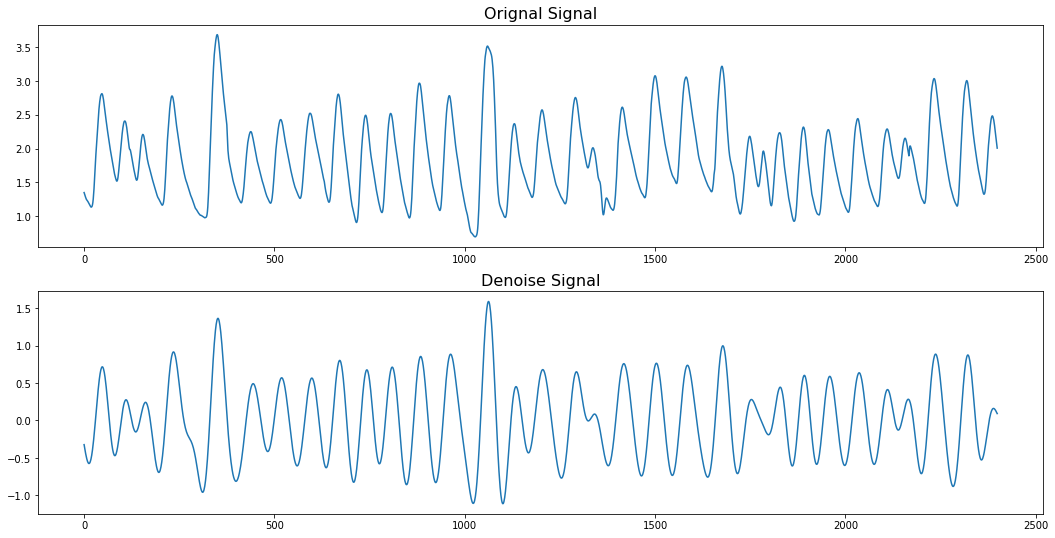

In [23]:
plt.figure(figsize=(18,9))
plt.subplot(211)
plt.plot(PPG)
plt.title('Orignal Signal', fontsize=16)
plt.subplot(212)
plt.plot(denoise)
plt.title('Denoise Signal', fontsize=16)
# plt.savefig('Sample Signal Subject '+str(subject)+' ('+str(bellow)+'.'+str(get)+').png')
plt.show()

#CLEANING 

## Atrial Fibrillation (AF)

In [24]:
import pandas as pd
import numpy as np
dfn1 = pd.read_csv('/content/hasil.csv')
dfn1

,Unnamed: 0,Time [s],RESP,II,V,AVR,PLETH
0,0,0.000,0.28390,0.19990,0.59531,0.54985,1.3060
1,1,0.008,0.27339,0.26002,0.58016,0.53519,1.2903
2,2,0.016,0.26313,0.31476,0.54008,0.50000,1.2747
3,3,0.024,0.25214,0.32991,0.50000,0.47019,1.2590
4,4,0.032,0.24139,0.36510,0.45992,0.45992,1.2444
...,...,...,...,...,...,...,...
59996,59996,479.970,0.96286,0.27468,0.44477,0.45015,1.2962
59997,59997,479.980,0.96164,0.26002,0.45503,0.45992,1.2884
59998,59998,479.980,0.96066,0.25464,0.48485,0.45015,1.2786
59999,59999,479.990,0.95749,0.22972,0.57527,0.42473,1.2678


In [25]:
#check type data
print(type(dfn1['II'][0]))
print(type(dfn1['PLETH'][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [26]:
#memotong data 
dfn1 = dfn1.loc[200:]
dfn1

,Unnamed: 0,Time [s],RESP,II,V,AVR,PLETH
200,200,1.600,0.65722,0.54008,0.63490,0.37977,2.0499
201,201,1.608,0.65893,0.58016,0.61486,0.37488,2.0108
202,202,1.616,0.66064,0.60508,0.60020,0.36999,1.9726
203,203,1.624,0.66259,0.61486,0.60020,0.36510,1.9345
204,204,1.632,0.66479,0.63490,0.59531,0.34995,1.8964
...,...,...,...,...,...,...,...
59996,59996,479.970,0.96286,0.27468,0.44477,0.45015,1.2962
59997,59997,479.980,0.96164,0.26002,0.45503,0.45992,1.2884
59998,59998,479.980,0.96066,0.25464,0.48485,0.45015,1.2786
59999,59999,479.990,0.95749,0.22972,0.57527,0.42473,1.2678


In [27]:
#pembersihan objek dr str yg tdk terpakai
dfn1['II'].replace('', np.nan, inplace=True)
dfn1.dropna(subset=['II'], inplace=True)
dfn1['PLETH'].replace('', np.nan, inplace=True)
dfn1.dropna(subset=['PLETH'], inplace=True)

dfn1.head(1)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Unnamed: 0,Time [s],RESP,II,V,AVR,PLETH
200,200,1.6,0.65722,0.54008,0.6349,0.37977,2.0499


In [28]:
dfn = pd.concat([dfn1]).reset_index(drop=True)
len(dfn)

59801

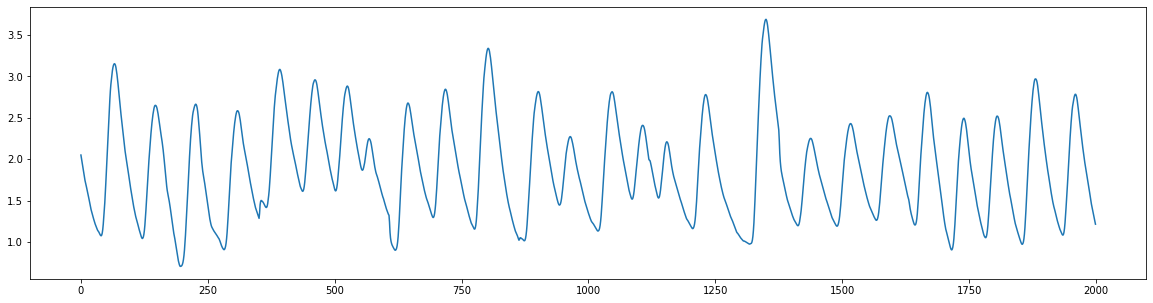

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(dfn['PLETH'][:2000])

In [30]:
dfn = dfn.loc[0:1899]
dfn.to_csv('hasilAFclean.csv')

## Premature ventricular contraction (PVC) 




In [31]:
dfv1 = pd.read_csv('/content/hasil.csv')
dfv1.head(1)

,Unnamed: 0,Time [s],RESP,II,V,AVR,PLETH
0,0,0.0,0.2839,0.1999,0.59531,0.54985,1.306


In [32]:
print(type(dfv1['II'][0]))
print(type(dfv1['PLETH'][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [33]:
dfv1['II'].replace('', np.nan, inplace=True)
dfv1.dropna(subset=['II'], inplace=True)
dfv1['PLETH'].replace('', np.nan, inplace=True)
dfv1.dropna(subset=['PLETH'], inplace=True)

dfv1.head(1)

,Unnamed: 0,Time [s],RESP,II,V,AVR,PLETH
0,0,0.0,0.2839,0.1999,0.59531,0.54985,1.306


In [34]:
dfv = pd.concat([dfv1]).reset_index(drop=True)
len(dfv)

60001

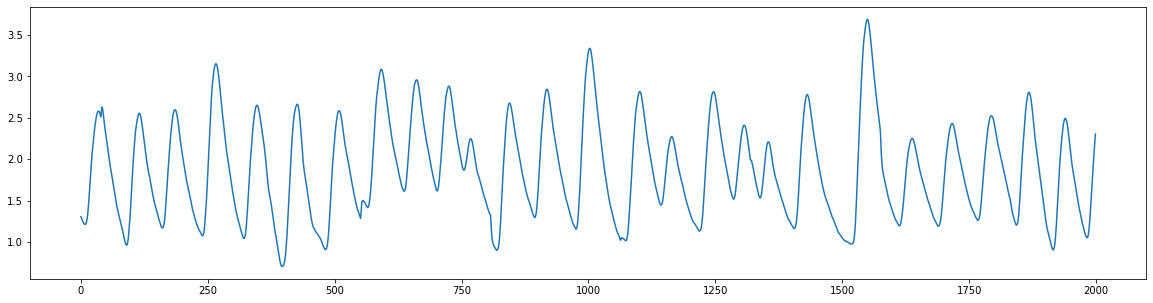

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(dfv['PLETH'][0:2000])

In [36]:
dfv = dfv.loc[0:1899]
dfv.to_csv('hasilPVCclean.csv')

###NORMAL

In [37]:
import pandas as pd
import numpy as np
dfn1 = pd.read_csv('/content/hasil.csv')

In [38]:
#check type data
print(type(dfn1['II'][0]))
print(type(dfn1['PLETH'][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [39]:
#memotong data 
dfn1 = dfn1.loc[100:]

In [40]:
#pembersihan objek dr str yg tdk terpakai
dfn1['II'].replace('', np.nan, inplace=True)
dfn1.dropna(subset=['II'], inplace=True)
dfn1['PLETH'].replace('', np.nan, inplace=True)
dfn1.dropna(subset=['PLETH'], inplace=True)

dfn1.head(1)

,Unnamed: 0,Time [s],RESP,II,V,AVR,PLETH
100,100,0.8,0.10213,0.18475,-0.10557,0.73021,1.6442


In [41]:
dfn = pd.concat([dfn1]).reset_index(drop=True)
len(dfn)

59901

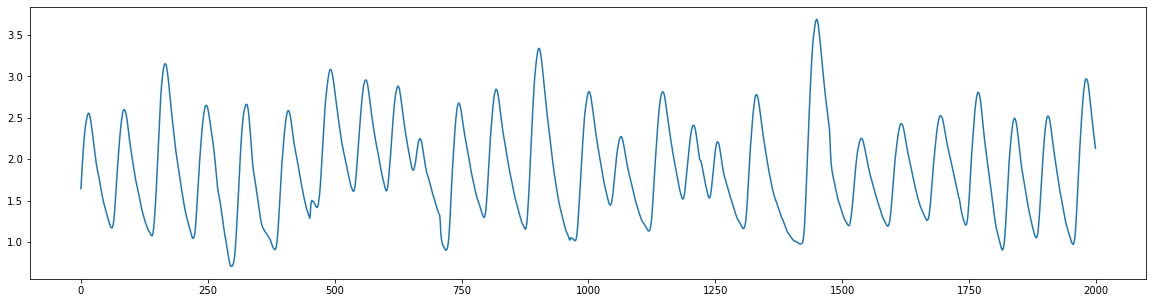

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(dfn['PLETH'][:2000])

In [43]:
dfn = dfn.loc[0:1899]
dfn.to_csv('hasilNClean.csv')

###PEAK SIGNAL


In [44]:
import pandas as pd
import numpy as np
dfn = pd.read_csv('/content/hasilAFclean.csv')
dfn

,Unnamed: 0,Unnamed: 0.1,Time [s],RESP,II,V,AVR,PLETH
0,0,200,1.600,0.65722,0.54008,0.63490,0.37977,2.0499
1,1,201,1.608,0.65893,0.58016,0.61486,0.37488,2.0108
2,2,202,1.616,0.66064,0.60508,0.60020,0.36999,1.9726
3,3,203,1.624,0.66259,0.61486,0.60020,0.36510,1.9345
4,4,204,1.632,0.66479,0.63490,0.59531,0.34995,1.8964
...,...,...,...,...,...,...,...,...
1895,1895,2095,16.760,0.21085,0.56989,0.67498,0.36510,2.3324
1896,1896,2096,16.768,0.21011,0.60508,0.67009,0.34506,2.2796
1897,1897,2097,16.776,0.20914,0.63001,0.65494,0.32991,2.2287
1898,1898,2098,16.784,0.20816,0.64027,0.63001,0.33480,2.1799


In [45]:
dfn.drop(['Unnamed: 0', 'Time [s]'], axis=1, inplace=True)
dfn.head(1)

,Unnamed: 0.1,RESP,II,V,AVR,PLETH
0,200,0.65722,0.54008,0.6349,0.37977,2.0499


In [46]:
# mencari peak sinyal pleth
import scipy.signal
peaksn,_ = scipy.signal.find_peaks(dfn['PLETH'], distance=30)
peaksn

array([  66,  147,  226,  308,  355,  392,  461,  525,  568,  644,  718,
        802,  866,  901,  964, 1047, 1107, 1154, 1231, 1307, 1350, 1438,
       1516, 1593, 1668, 1740, 1805, 1881])

In [47]:
# hasil peak sinyal pleth
peaksnidxn = dfn['PLETH'][peaksn]
print(peaksnidxn)

66      3.1525
147     2.6500
226     2.6637
308     2.5846
355     1.5015
392     3.0841
461     2.9580
525     2.8827
568     2.2473
644     2.6774
718     2.8446
802     3.3372
866     1.0518
901     2.8162
964     2.2727
1047    2.8133
1107    2.4086
1154    2.2092
1231    2.7801
1307    1.0117
1350    3.6882
1438    2.2512
1516    2.4291
1593    2.5230
1668    2.8065
1740    2.4936
1805    2.5200
1881    2.9697
Name: PLETH, dtype: float64


In [48]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

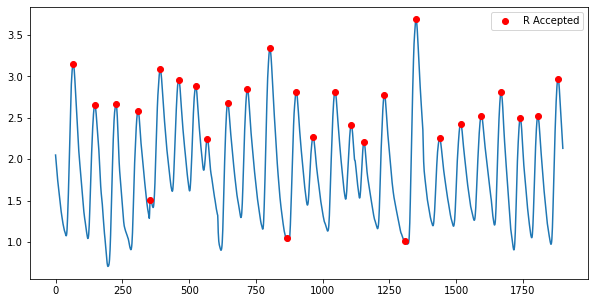

In [49]:
#plot peak R sinyal kedalam grafik
peakslabel = mlines.Line2D([], [], color='red', linestyle=' ', marker='o', label='R Accepted')
plt.figure(figsize=(10, 5))
plt.legend(handles=[peakslabel])
plt.plot(dfn['PLETH'])
plt.plot(peaksnidxn, 'o', color='red')

#EKSTRAKSI FITUR

##DICRETE WAVELET TRANSFORM

In [50]:
import pandas as pd
import numpy as np

import pywt
import statistics
import matplotlib.pyplot as plt
from scipy.signal import resample, find_peaks
from statsmodels.robust import mad

In [51]:
def waveletSmooth(x, wavelet="db4", level=1, title=None ):
    coeff = pywt.wavedec( x, wavelet, mode="per")
    sigma = mad( coeff[-level] )
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

In [52]:
def dwt_extraction(ppg):
    # Preprocessing using Wavelet Smoothing 
    sinyal = waveletSmooth(ppg)

    # Extraction using Multilevel 1D Discrete Wavelet Transform
    coeff = pywt.wavedec( ppg_out,'sym8', level=1)
    return {'min': coeff[0].min(), 
            'max': coeff[0].max(), 
            'mean': statistics.mean(coeff[0]), 
            'med': statistics.median(coeff[0]), 
            'std': statistics.stdev(coeff[0])}

In [53]:
labels = [{'name': 'AF', 'dataset': 'AF1KOSONG.csv', 'loops': 50, 'sample_rate': 50, 'windows': 100}, 
            {'name': 'N', 'dataset': 'nclean.csv', 'loops': 19, 'sample_rate': 50, 'windows': 100},
            {'name': 'PVC', 'dataset': 'PVC1KOSONG.csv', 'loops': 12, 'sample_rate': 50, 'windows': 500}
         ]    

##ENTROPY FEATURES 





In [54]:
import statistics as st
import numpy as np
import pandas as pd
import scipy.stats as scst

In [55]:
from numpy.ma.core import std
def shannon(x):
  y=np.power(x,2)
  y1=np.sum(y)
  PE = y/y1
  std=np.sum(PE*np.log(np.power(PE,2)))
  return std

In [56]:
data = pd.read_csv('/content/hasilAFclean.csv')
data.drop(['PLETH','II'], axis=1, inplace=True)
data.to_csv("NBARU")

In [57]:
#Loop on method based on Data Length 
#Use the k parameter to set the amount of data you want to split
data = pd.read_csv('/content/drive/MyDrive/DATABASE/model/datareadyPVC.csv')
k = 5
STAT = pd.DataFrame(index=range(len(data)//k), columns=['std',
                                                        'label'])
  
for i in range(len(data)//k):
  start = i * k
  end = (i + 1) * k
  x = data.iloc[start:end,3].values

  STAT['std'][i] = shannon(x)
  STAT['label'][i] = 'PVC'

In [58]:
  STAT.to_csv('resultAFclean.csv') 

In [59]:
STAT

,std,label
0,-3.16789,PVC
1,-3.215798,PVC
2,-3.217079,PVC
3,-1.917014,PVC
4,-2.734523,PVC


#MENCARI AKURASI DENGAN KNN

##KNN


In [60]:
import pandas as pd
import numpy as np

In [61]:
df = pd.read_csv('/content/drive/MyDrive/DATABASE/predictfitur/datareadyAFPVC.csv')
df['std'].replace('', np.nan, inplace=True)
df.dropna(subset=['std'], inplace=True)
df['std'].replace('', np.nan, inplace=True)
df.dropna(subset=['std'], inplace=True)

In [62]:
df
df.to_csv("data.csv")

In [63]:
x = df[['min','max','std','med','mean']]
# x = df[['min','max','std','med','mean']]
y = df['label']

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.5,random_state=109)

In [65]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9708029197080292


In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[192,   0,   0],
       [  3,  53,   1],
       [  0,   4,  21]])

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,))

              precision    recall  f1-score   support

          AF       0.98      1.00      0.99       192
           N       0.93      0.93      0.93        57
         PVC       0.95      0.84      0.89        25

    accuracy                           0.97       274
   macro avg       0.96      0.92      0.94       274
weighted avg       0.97      0.97      0.97       274



In [68]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(model, X_test, y_test, cv=10)
score

array([0.96428571, 1.        , 1.        , 1.        , 0.96296296,
       0.96296296, 1.        , 1.        , 0.96296296, 0.96296296])

#AKURASI DATA DWT



In [69]:
df_test1 = pd.read_csv('/content/drive/MyDrive/DATABASE/predictfitur/AF5.csv')


In [70]:
x = df_test1[['min','max','mean','med','std',]]
# x = df_test1[['se']]
y = df_test1['label']

In [71]:
y_pred = model.predict(x)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [72]:
print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 0.9292929292929293


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred,))

              precision    recall  f1-score   support

          AF       0.93      1.00      0.96        90
           N       1.00      0.22      0.36         9

    accuracy                           0.93        99
   macro avg       0.96      0.61      0.66        99
weighted avg       0.93      0.93      0.91        99



In [74]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(model, x, y_pred, cv=10)
score

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9       , 0.9       , 0.88888889])

#Akurasi Nilai Entropy

In [75]:
df_test2 = pd.read_csv('/content/drive/MyDrive/DATABASE/predictfitur/PVC1.csv')
df_test2.head

<bound method NDFrame.head of          min       max      mean       med       std label
0   0.179276  0.934682  0.442673  0.281238  0.306842     N
1  -0.534120  2.335418  0.465980 -0.154240  1.166426   PVC
2   0.752510  1.940157  1.166505  0.908606  0.482875     N
3   0.932270  1.456050  1.114902  1.001796  0.212887     N
4   0.654619  1.287968  0.875421  0.738803  0.257411     N
..       ...       ...       ...       ...       ...   ...
61  0.308206  0.691059  0.441673  0.359116  0.155599     N
62 -0.345531  1.675065  0.358728 -0.073993  0.820912   PVC
63  0.133811  2.093402  0.816817  0.391362  0.796744   PVC
64  0.902128  1.504309  1.112076  0.981387  0.244827     N
65  0.718012  1.228091  0.895839  0.785967  0.207294     N

[66 rows x 6 columns]>

In [76]:
y_pred = model.predict(x)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [77]:
print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 0.9292929292929293


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred,))

              precision    recall  f1-score   support

          AF       0.93      1.00      0.96        90
           N       1.00      0.22      0.36         9

    accuracy                           0.93        99
   macro avg       0.96      0.61      0.66        99
weighted avg       0.93      0.93      0.91        99



In [79]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(model, x, y_pred, cv=10)
score

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9       , 0.9       , 0.88888889])